In [1]:
cd ../

c:\Users\Nicole\Desktop\MDS\capstone\canucks_mds_capstone


c:\Users\Nicole\miniconda3\envs\canucks_pricing\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from src.cross_validation import *
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from src.cross_validation import *
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

import statsmodels.api as sm


In [3]:
X_train = pd.read_parquet('data/output/X_train.parquet')
y_train = pd.read_parquet('data/output/y_train.parquet')

Poisson with sklearn 

In [4]:
def poisson(numeric_feats, categorical_feats, passthrough_feats, alpha=1): 

    all_columns = set(X_train.columns)
    rest_columns = set(numeric_feats + categorical_feats + passthrough_feats)
    drop_feats = list(all_columns - rest_columns)   

    preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_feats), 
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numeric_feats),
        ('boolean','passthrough', passthrough_feats),
        ('categorical', Pipeline([
            ('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'))
        ]), categorical_feats)
        ]
    )

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poisson_regressor', PoissonRegressor(alpha=alpha))
    ])

    model.fit(X_train, y_train.to_numpy().ravel())


    # to observe coefficients
    cat_feature_names = model.named_steps['preprocessor'].transformers_[3][1].named_steps['onehot'].get_feature_names_out(categorical_feats)
    feature_names = np.concatenate((numeric_feats, passthrough_feats, cat_feature_names))
    coefficients = (model.named_steps['poisson_regressor'].coef_).reshape(-1)

    df_coef = pd.DataFrame({'feature': feature_names, 'coefficients': coefficients})
    df_coef = df_coef.sort_values(by='coefficients', ascending=False)
    df_coef['mag'] = df_coef['coefficients'].abs()
    df_coef = df_coef.sort_values(by='mag', ascending=False)

    return model, df_coef


In [15]:
numeric_feats = ['s/t-rate', 'opens',
'host_sold-total', 'host_sold-last_7days', 'host_sold-yesterday', 
'resale_sold-last_7days', 'resale_sold-total', 'resale_asp-last_7days', 'resale_asp-total', 'number_of_postings', 'median_posting_price',
'posting_below_cp', 'lowest_post_price', 'highest_post_price', 'host_sold_at_current_price', 'days_until_game', 
'opponent_rank', 'van_rank','host_sold_agg_last_day','unique_views', 'price_code_ordinal', 
'tickets_sold_2_days_before_today', 'tickets_sold_3_days_before_today', 
'tickets_sold_4_days_before_today', 'tickets_sold_5_days_before_today', 
'tickets_sold_6_days_before_today', 'tickets_sold_7_days_before_today', ]

categorical_feats = ['month', 'opponent']

passthrough_feats = ['bowl_location', 'weekend_game', 'inventory_normalized', 'times_above_floor']

In [44]:
model, df_coef = poisson(numeric_feats, categorical_feats, passthrough_feats, alpha=1)

In [45]:
eval_model(model, X_train, y_train['target_host_sold-today'])

Training date range: 2022-01-20 00:00:00 - 2023-03-12 00:00:00
Validation date range: 2023-03-13 00:00:00 - 2023-10-14 00:00:00
Validation Root Mean Squared Error: 3.071685531696927
Training date range: 2022-01-20 00:00:00 - 2023-10-14 00:00:00
Validation date range: 2023-10-15 00:00:00 - 2023-12-13 00:00:00
Validation Root Mean Squared Error: 3.723777524414196
Training date range: 2022-01-20 00:00:00 - 2023-12-13 00:00:00
Validation date range: 2023-12-14 00:00:00 - 2023-12-31 00:00:00
Validation Root Mean Squared Error: 1.888223469214956
All Validation Scores: [3.071685531696927, 3.723777524414196, 1.888223469214956]
Mean Validation Score: 2.894562175108693
Standard Deviation of Validation Scores: 0.7597561823709875


In [46]:
y_train_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train_pred, y_train))
rmse_train

3.6208999009279803

In [47]:
# Validation with cross_val_score 
def rmse(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse)

valid_scores = cross_val_score(model, X_train, y_train.to_numpy().ravel(), cv=5, scoring=rmse_scorer)
np.set_printoptions(suppress=True)

valid_scores

array([    2.58950714, 77771.96098116,     2.54315146,     2.74348609,
           3.51670557])

In [48]:
# Validation with KFold 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, valid_index in kf.split(X_train):
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    model, df_coef = poisson(numeric_feats, categorical_feats, passthrough_feats, alpha=1.0)
    
    y_pred = model.predict(X_valid_fold)
    
    rmse = np.sqrt(mean_squared_error(y_valid_fold, y_pred))
    print("Validation RMSE:", rmse)

Validation RMSE: 3.677244133107553
Validation RMSE: 4.203158126215354
Validation RMSE: 3.3698024224288505
Validation RMSE: 3.6420474270253567
Validation RMSE: 3.206001462870317


In [49]:
def plot_demand_curve(model, data_path):

    # Load the data
    X_train = pd.read_parquet(data_path)

    # Select a sample entry
    sample_entry = X_train.iloc[[1102, 1198, 35782, 63375]]

    # Define a range of ticket prices to test
    ticket_prices = np.linspace(0, 8, num=30)

    # Store predictions
    predictions = []
    plt.figure(figsize=(8, 8))
    # Change the ticket price in the sample entry and predict tickets sold
    # For each sample entry, change the ticket price and predict tickets sold
    for i in range(len(sample_entry)):
        predictions = []
        for price in ticket_prices:
            modified_entry = sample_entry.iloc[[i]].copy()
            modified_entry['times_above_floor'] = price
            predicted_tickets_sold = model.predict(modified_entry)[0]
            predictions.append(predicted_tickets_sold)

        # Get the values for 'event_name', 'calculate_date', and 'price_code'
        event_name = modified_entry['event_name'].values[0]
        
        # Convert 'calculate_date' to datetime and format it
        calculate_date = pd.to_datetime(modified_entry['calculate_date'].values[0]).strftime('%Y-%m-%d')
        
        price_code = modified_entry['price_code'].values[0]

        # Create a label with these values
        label = f"Event: {event_name}, Date: {calculate_date}, Price Code: {price_code}"

        # Plotting the demand curve for each entry
        plt.plot(ticket_prices, predictions, marker='o', label=label)

    
    plt.title('Predicted Tickets Sold vs. Ticket Price')
    plt.xlabel('Ticket Price - times above floor')
    plt.ylabel('Predicted Tickets Sold')
    plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center')
    plt.subplots_adjust(bottom=0.3)
    plt.grid(True)
    plt.show()

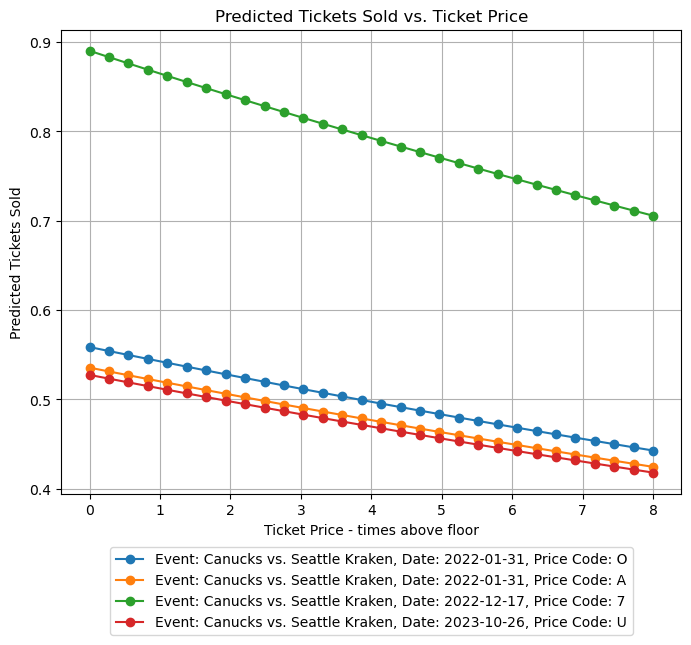

In [50]:
plot_demand_curve(model, 'data/output/X_train.parquet')

OLD - poisson with statsmodels 

In [3]:
# Features used 
numeric_feats = ['s/t-rate', 'opens', 'prp_forwardtix',  
'host_sold-total', 'host_sold-last_7days', 'host_sold-yesterday', 'resale_sold-last_7days', 
'resale_sold-total', 'resale_asp-last_7days', 'resale_asp-total', 'number_of_postings', 'median_posting_price',
'posting_below_cp', 'lowest_post_price', 'highest_post_price', 'host_sold_at_current_price', 'days_until_game', 
'opponent_rank', 'van_rank','host_sold_agg_last_day', 'unique_views', 'price_code_ordinal', 
'tickets_sold_2_days_before_today', 'tickets_sold_3_days_before_today', 
'tickets_sold_4_days_before_today', 'tickets_sold_5_days_before_today', 
'tickets_sold_6_days_before_today', 'tickets_sold_7_days_before_today', ]

categorical_feats = ['month', 'opponent']

passthrough_feats = ['weekend_game', 'inventory_normalized', 'times_above_floor']

In [26]:
def sksm_poisson(numeric_feats, categorical_feats, passthrough_feats, train_days=270, validation_days=60): 

    X_train = pd.read_parquet('data/output/X_train.parquet')
    y_train = pd.read_parquet('data/output/y_train.parquet')

    all_columns = set(X_train.columns)
    rest_columns = set(numeric_feats + categorical_feats + passthrough_feats)
    drop_feats = list(all_columns - rest_columns)

    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('drop', 'drop', drop_feats), 
            ('numeric', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                ('scaler', StandardScaler())
            ]), numeric_feats),
            ('boolean','passthrough', passthrough_feats),
            ('categorical', Pipeline([
                ('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'))
            ]), categorical_feats)
        ]
    )

    # CROSS VALIDATION
    validation_scores = []
    r2_scores = []

    # Perform sliding window cross-validation
    X_train['calculate_date'] = pd.to_datetime(X_train['calculate_date'])
    X_train = X_train.sort_values('calculate_date')
    y_train = y_train.reindex(X_train.index)
    dates = X_train['calculate_date'].dt.date.unique()

    for i in range(train_days, len(dates), validation_days):
        train_dates = pd.to_datetime(dates[:i])
        validation_dates = pd.to_datetime(dates[i:i+validation_days])
        X_train_fold = X_train[X_train['calculate_date'].isin(train_dates)]
        y_train_fold = y_train.loc[X_train_fold.index]
        X_validation_fold = X_train[X_train['calculate_date'].isin(validation_dates)]
        y_validation_fold = y_train.loc[X_validation_fold.index]

        # Preprocess training data
        X_train_processed = preprocessor.fit_transform(X_train_fold)
        X_train_processed = sm.add_constant(X_train_processed)

        # Fit the model
        model = sm.GLM(y_train_fold, X_train_processed, family=sm.families.Poisson()).fit()

        # Preprocess validation data
        X_val_processed = preprocessor.transform(X_validation_fold)
        X_val_processed = sm.add_constant(X_val_processed)

        # Predict on validation set
        y_pred_val = model.predict(X_val_processed)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_validation_fold, y_pred_val))
        validation_scores.append(rmse)
        r2 = r2_score(y_validation_fold, y_pred_val)
        r2_scores.append(r2)

        print(f'Validation Root Mean Squared Error: {rmse}')
        print(f'R^2 Validation: {r2}')

    # Calculate mean validation score
    mean_score = np.mean(validation_scores)
    mean_r2 = np.mean(r2_scores)
    print(f'Mean Validation Score: {mean_score}')
    print(f'Mean r2 Validation Score: {mean_r2}')


    # fit the model on the entire training set 
    X_train_processed = preprocessor.fit_transform(X_train)
    X_train_processed = sm.add_constant(X_train_processed)
    model = sm.GLM(y_train, X_train_processed, family=sm.families.Poisson()).fit()

    return model, X_train_processed, preprocessor


In [27]:
model, X_train_processed, preprocessor = sksm_poisson(numeric_feats, categorical_feats, passthrough_feats)

Validation Root Mean Squared Error: 3.083163016876724
R^2 Validation0.17169530753293294
Validation Root Mean Squared Error: 7.664792723846503
R^2 Validation-2.34129811024054
Validation Root Mean Squared Error: 2.090141576823993
R^2 Validation-0.13323333846921726
Mean Validation Score: 4.27936577251574
Mean r2 Validation Score: -0.7676120470589414


In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     target_host_sold-today   No. Observations:                74408
Model:                                GLM   Df Residuals:                    74338
Model Family:                     Poisson   Df Model:                           69
Link Function:                        Log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:            -1.4072e+05
Date:                    Tue, 04 Jun 2024   Deviance:                   2.1910e+05
Time:                            11:08:46   Pearson chi2:                 4.23e+05
No. Iterations:                       100   Pseudo R-squ. (CS):             0.7738
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1431      0.018     -8.133      0.000      -0.178      -0.109
x1             0.0175      0.006      2.921      0.003       0.006       0.029
x2             0.2506      0.004     61.240      0.000       0.243       0.259
x3             0.1062      0.004     25.404      0.000       0.098       0.114
x4             0.1532      0.004     35.737      0.000       0.145       0.162
x5            -0.3498      0.013    -26.839      0.000      -0.375      -0.324
x6             0.1252      0.004     33.116      0.000       0.118       0.133
x7             0.0209      0.004      4.967      0.000       0.013       0.029
x8            -0.0383      0.006     -6.492      0.000      -0.050      -0.027
x9             0.0879      0.006     14.711      0.000       0.076       0.100
x10            0.0201      0.008      2.447      0.014       0.004       0.036
x11            0.1136      0.005     22.801      0.000       0.104       0.123
x12            0.0066      0.009      0.706      0.480      -0.012       0.025
x13           -0.0426      0.004    -10.488      0.000      -0.051      -0.035
x14           -0.0043      0.010     -0.417      0.676      -0.025       0.016
x15           -0.0067      0.004     -1.618      0.106      -0.015       0.001
x16            0.0915      0.003     31.320      0.000       0.086       0.097
x17           -0.4781      0.005    -94.942      0.000      -0.488      -0.468
x18            0.0017      0.005      0.314      0.753      -0.009       0.012
x19           -0.0706      0.004    -16.965      0.000      -0.079      -0.062
x20           -0.0492      0.003    -17.111      0.000      -0.055      -0.044
x21            0.1892      0.003     56.104      0.000       0.183       0.196
x22           -0.3196      0.006    -50.618      0.000      -0.332      -0.307
x23            0.1118      0.004     31.491      0.000       0.105       0.119
x24            0.1100      0.004     31.254      0.000       0.103       0.117
x25            0.1067      0.004     30.361      0.000       0.100       0.114
x26            0.0958      0.004     25.753      0.000       0.089       0.103
x27            0.0960      0.004     26.189      0.000       0.089       0.103
x28            0.0942      0.004     25.797      0.000       0.087       0.101
x29            0.0395      0.009      4.177      0.000       0.021       0.058
x30            2.0902      0.064     32.431      0.000       1.964       2.217
x31           -0.1641      0.011    -15.191      0.000      -0.185      -0.143
x32           -0.2505      0.017    -15.108      0.000      -0.283      -0.218
x33           -0.1208      0.015     -8.296      0.000      -0.149      -0.092
x34            0.0802      0.009      9.210      0.000       0.063       0.097
x35            0.1101      0.010     

In [48]:
y_train = pd.read_parquet('data/output/y_train.parquet')
X_train = pd.read_parquet('data/output/X_train.parquet')

In [52]:
X_train_pro = preprocessor.transform(X_train)
X_train_pro = sm.add_constant(X_train_pro)
y_train_pred = model.predict(X_train_processed)
rmse_train = np.sqrt(np.mean((y_train['target_host_sold-today'] - y_train_pred) ** 2))

In [54]:
rmse_train

4.352769317410217

In [21]:
def plot_demand_curve(model, preprocessor, data_path, sample_indices):
    
    # Load the data
    X_train = pd.read_parquet(data_path)

    # Select sample entries
    sample_entries = X_train.iloc[sample_indices]

    # Define a range of ticket prices to test
    ticket_prices = np.linspace(0, 8, num=30)

    plt.figure(figsize=(8, 8))

    for i, sample_entry in sample_entries.iterrows():
        predictions = []
        for price in ticket_prices:
            modified_entry = sample_entry.copy()
            modified_entry['times_above_floor'] = price

            # Convert the modified entry to a DataFrame and preprocess it
            modified_entry = pd.DataFrame([modified_entry])
            modified_entry_preprocessed = preprocessor.transform(modified_entry)
            modified_entry_preprocessed = sm.add_constant(modified_entry_preprocessed, has_constant='add')

            # Predict the number of tickets sold
            predicted_tickets_sold = model.predict(modified_entry_preprocessed)[0]
            predictions.append(predicted_tickets_sold)

        # Get the values for 'event_name', 'calculate_date', and 'price_code'
        event_name = sample_entry['event_name']
        calculate_date = pd.to_datetime(sample_entry['calculate_date']).strftime('%Y-%m-%d')
        price_code = sample_entry['price_code']

        # Create a label with these values
        label = f"Event: {event_name}, Date: {calculate_date}, Price Code: {price_code}"

        # Plotting the demand curve for each entry
        plt.plot(ticket_prices, predictions, marker='o', label=label)

    plt.title('Demand Curve - Poisson Model')
    plt.xlabel('Price above Floor')
    plt.ylabel('Predicted Tickets Sold')
    plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center')
    plt.subplots_adjust(bottom=0.3)
    plt.grid(True)
    plt.show()

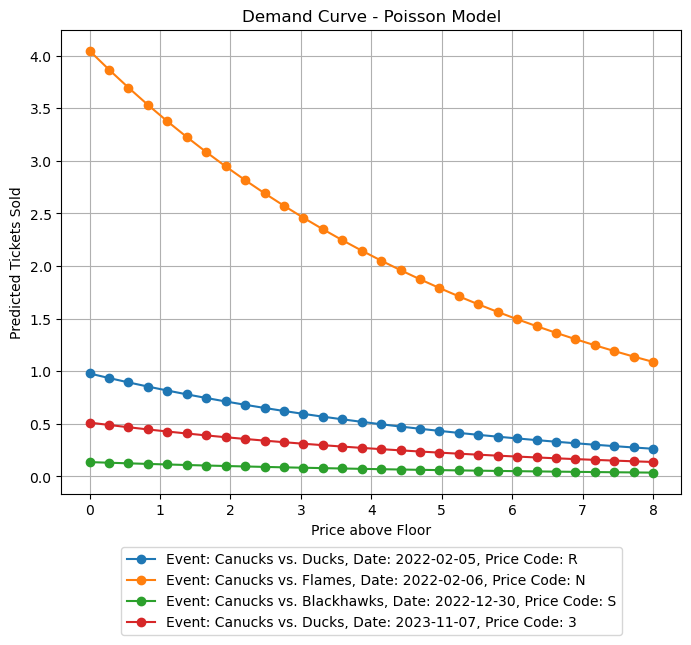

In [24]:
plot_demand_curve(model, preprocessor, 'data/output/X_train.parquet', sample_indices=[1102, 1198, 35782, 63375])

Residual Plots 

In [28]:
y_train_values = y_train['target_host_sold-today'].values 
rest_columns = set(numeric_feats + categorical_feats + passthrough_feats)
y_pred =  y_pred.reshape(-1)
residuals = y_train_values - y_pred
X_train['residuals'] = residuals

In [31]:
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [94]:
# residual_plots = []

# for feature in rest_columns: 
#     scatter = alt.Chart(X_train).mark_circle().encode(
#         x=feature, 
#         y='residuals:Q'
#     ).properties(
#         title=f'Residual Plot for {feature}'
#     )
#     residual_plots.append(scatter)
# plots = alt.vconcat(*residual_plots)

In [20]:
def sm_poisson(numeric_feats, categorical_feats, passthrough_feats): 

    X_train = pd.read_parquet('data/output/X_train.parquet')
    y_train = pd.read_parquet('data/output/y_train.parquet')

    all_columns = set(X_train.columns)
    rest_columns = set(numeric_feats + categorical_feats + passthrough_feats)
    drop_feats = list(all_columns - rest_columns)

    # PREPROCESSING
    # drop columns
    X_train = X_train.drop(columns=drop_feats)

    # Fill NaN values in numeric columns with 0
    X_train[numeric_feats] = X_train[numeric_feats].fillna(0)

    # Standardize numeric columns
    X_train[numeric_feats] = (X_train[numeric_feats] - X_train[numeric_feats].mean())/X_train[numeric_feats].std()

    # OHE for categorical columns
    X_train = pd.get_dummies(X_train, columns=categorical_feats, drop_first=True)
    boolean_cols = X_train.columns[X_train.dtypes == 'bool']
    X_train[boolean_cols] = X_train[boolean_cols].astype(int)

    # Add constant    
    X_train = sm.add_constant(X_train)

    # fit the model on the entire training set 
    model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

    return model, X_train
    

In [7]:
model, X_train_processed = sm_poisson(numeric_feats, categorical_feats, passthrough_feats) 

In [8]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     target_host_sold-today   No. Observations:                74408
Model:                                GLM   Df Residuals:                    74340
Model Family:                     Poisson   Df Model:                           67
Link Function:                        Log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:            -1.4072e+05
Date:                    Tue, 04 Jun 2024   Deviance:                   2.1910e+05
Time:                            10:00:39   Pearson chi2:                 4.23e+05
No. Iterations:                       100   Pseudo R-squ. (CS):             0.7738
Covariance Type:                nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               -0.3768      0.024    -15.507      0.000      -0.424      -0.329
s/t-rate                             0.0175      0.006      2.923      0.003       0.006       0.029
opens                                0.2506      0.004     61.276      0.000       0.243       0.259
prp_forwardtix                       0.1062      0.004     25.411      0.000       0.098       0.114
host_sold-total                      0.1532      0.004     35.758      0.000       0.145       0.162
host_sold-last_7days                -0.3498      0.013    -26.840      0.000      -0.375      -0.324
host_sold-yesterday                  0.1252      0.004     33.117      0.000       0.118       0.133
resale_sold-last_7days               0.0209      0.004      4.967      0.000       0.013       0.029
resale_sold-total                   -0.0383      0.006     -6.493      0.000      -0.050      -0.027
resale_asp-last_7days                0.0879      0.006     14.715      0.000       0.076       0.100
resale_asp-total                     0.0201      0.008      2.447      0.014       0.004       0.036
number_of_postings                   0.1136      0.005     22.796      0.000       0.104       0.123
median_posting_price                 0.0065      0.009      0.702      0.483      -0.012       0.025
posting_below_cp                    -0.0426      0.004    -10.491      0.000      -0.051      -0.035
lowest_post_price                   -0.0043      0.010     -0.416      0.677      -0.025       0.016
highest_post_price                  -0.0067      0.004     -1.613      0.107      -0.015       0.001
host_sold_at_current_price           0.0915      0.003     31.328      0.000       0.086       0.097
tickets_sold_2_days_before_today     0.1118      0.004     31.482      0.000       0.105       0.119
tickets_sold_3_days_before_today     0.1100      0.004     31.254      0.000       0.103       0.117
tickets_sold_4_days_before_today     0.1067      0.004     30.373      0.000       0.100       0.114
tickets_sold_5_days_before_today     0.0958      0.004     25.757      0.000       0.089       0.103
tickets_sold_6_days_before_today     0.0960      0.004     26.235      0.000       0.089       0.103
tickets_sold_7_days_before_today     0.0942      0.004     25.808      0.000       0.087       0.101
weekend_game                         0.0395      0.009      4.178      0.000       0.021       0.058
days_until_game                     -0.4781      0.005    -94.956      0.000      -0.488      -0.468
opponent_rank                       -0.0081      0.014     -0.595      0.552      -0.035       0.019
van_rank                            -0.0706      0.004    -16.968      0.000      -0.079      -0.062
host_sold

Polynomial Features

In [52]:
def poisson_poly(numeric_feats, categorical_feats, passthrough_feats, alpha=1.0, deg_val=2): 

    all_columns = set(X_train.columns)
    rest_columns = set(numeric_feats + categorical_feats + passthrough_feats)
    drop_feats = list(all_columns - rest_columns)   

    preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_feats), 
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('poly', PolynomialFeatures(degree=deg_val)),
            ('scaler', StandardScaler())
        ]), numeric_feats),
        ('boolean','passthrough', passthrough_feats),
        ('categorical', Pipeline([
            ('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'))
        ]), categorical_feats)
        ]
    )

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poisson_regressor', PoissonRegressor(alpha=alpha, max_iter=1000))
    ])

    model.fit(X_train, y_train.to_numpy().ravel())


    # to observe coefficients
    poly = model.named_steps['preprocessor'].transformers_[1][1].named_steps['poly']
    poly_feature_indices = poly.get_feature_names_out(input_features=numeric_feats)
    poly_feature_names = [f'poly_{name}' for name in poly_feature_indices]

    cat_feature_names = model.named_steps['preprocessor'].transformers_[3][1].named_steps['onehot'].get_feature_names_out(categorical_feats)
    feature_names = np.concatenate((poly_feature_names, passthrough_feats, cat_feature_names))
    coefficients = (model.named_steps['poisson_regressor'].coef_).reshape(-1)

    df_coef = pd.DataFrame({'feature': feature_names, 'coefficients': coefficients})
    df_coef = df_coef.sort_values(by='coefficients', ascending=False)
    df_coef['mag'] = df_coef['coefficients'].abs()
    df_coef = df_coef.sort_values(by='mag', ascending=False)

    return model, df_coef

In [53]:
model_sk, df_coef = poisson_poly(numeric_feats=numeric_feats, categorical_feats=categorical_feats, passthrough_feats=passthrough_feats)

In [54]:
eval_model(model_sk, X_train, y_train['target_host_sold-today'])

Training date range: 2022-01-20 00:00:00 - 2023-03-12 00:00:00
Validation date range: 2023-03-13 00:00:00 - 2023-10-14 00:00:00
Validation Root Mean Squared Error: 3.1955986399453966
Training date range: 2022-01-20 00:00:00 - 2023-10-14 00:00:00
Validation date range: 2023-10-15 00:00:00 - 2023-12-13 00:00:00
Validation Root Mean Squared Error: 4.202324023702802
Training date range: 2022-01-20 00:00:00 - 2023-12-13 00:00:00
Validation date range: 2023-12-14 00:00:00 - 2023-12-31 00:00:00
Validation Root Mean Squared Error: 1.757020383381991
All Validation Scores: [3.1955986399453966, 4.202324023702802, 1.757020383381991]
Mean Validation Score: 3.051647682343397
Standard Deviation of Validation Scores: 1.003466950788599


In [56]:
y_train_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train_pred, y_train))
rmse_train

3.635579890058145

Random Search

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [61]:
# Random Search with CV

def poisson_search(numeric_feats, categorical_feats, passthrough_feats):

    all_columns = set(X_train.columns)
    rest_columns = set(numeric_feats + categorical_feats + passthrough_feats)
    drop_feats = list(all_columns - rest_columns)   

    preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_feats), 
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('poly', PolynomialFeatures()),
            ('scaler', StandardScaler())
        ]), numeric_feats),
        ('boolean','passthrough', passthrough_feats),
        ('categorical', Pipeline([
            ('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'))
        ]), categorical_feats)
        ]
    )

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poisson_regressor', PoissonRegressor())
    ])

    # search space
    param_dist = {
        'preprocessor__numeric__poly__degree': randint(1, 3), # deg 1 or 2 
        'poisson_regressor__alpha': uniform(0, 10000)  # regularization 
    }
    # Perform random search
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42) 
    random_search.fit(X_train,y_train.to_numpy().ravel())

    best_model = random_search.best_estimator_

    return best_model

In [62]:
model = poisson_search(numeric_feats, categorical_feats, passthrough_feats)

In [63]:
best_alpha = model.named_steps['poisson_regressor'].alpha
best_alpha

1834.347898661638

In [64]:
best_degree = model.named_steps['preprocessor'].transformers_[1][1].named_steps['poly'].degree
best_degree

2

In [65]:
y_train_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train_pred, y_train))
rmse_train

3.7213522687750173

In [66]:
# Random Search with KFold 

def poisson_search(numeric_feats, categorical_feats, passthrough_feats):
    all_columns = set(X_train.columns)
    rest_columns = set(numeric_feats + categorical_feats + passthrough_feats)
    drop_feats = list(all_columns - rest_columns)   

    preprocessor = ColumnTransformer(
        transformers=[
            ('drop', 'drop', drop_feats), 
            ('numeric', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                ('poly', PolynomialFeatures()),
                ('scaler', StandardScaler())
            ]), numeric_feats),
            ('boolean', 'passthrough', passthrough_feats),
            ('categorical', Pipeline([
                ('onehot', OneHotEncoder(categories='auto', handle_unknown='ignore'))
            ]), categorical_feats)
        ]
    )

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poisson_regressor', PoissonRegressor(max_iter=1000))
    ])

    # Search space
    param_dist = {
        'preprocessor__numeric__poly__degree': randint(1, 3),  # deg 1 or 2
        'poisson_regressor__alpha': uniform(0, 1000)  # regularization
    }

    # KFold cross-validation
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)

    # Perform random search with k-fold cross-validation
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=kfold, scoring='neg_mean_squared_error', random_state=42) 
    random_search.fit(X_train, y_train.to_numpy().ravel())

    best_model = random_search.best_estimator_

    return best_model


In [67]:
model = poisson_search(numeric_feats, categorical_feats, passthrough_feats)

In [68]:
best_alpha = model.named_steps['poisson_regressor'].alpha
best_alpha

832.4426408004217

In [69]:
best_degree = model.named_steps['preprocessor'].transformers_[1][1].named_steps['poly'].degree
best_degree

2

In [70]:
eval_model(model, X_train, y_train['target_host_sold-today'])

Training date range: 2022-01-20 00:00:00 - 2023-03-12 00:00:00
Validation date range: 2023-03-13 00:00:00 - 2023-10-14 00:00:00
Validation Root Mean Squared Error: 3.335952140631582
Training date range: 2022-01-20 00:00:00 - 2023-10-14 00:00:00
Validation date range: 2023-10-15 00:00:00 - 2023-12-13 00:00:00
Validation Root Mean Squared Error: 4.142560457556755
Training date range: 2022-01-20 00:00:00 - 2023-12-13 00:00:00
Validation date range: 2023-12-14 00:00:00 - 2023-12-31 00:00:00
Validation Root Mean Squared Error: 2.0538901548070623
All Validation Scores: [3.335952140631582, 4.142560457556755, 2.0538901548070623]
Mean Validation Score: 3.1774675843317994
Standard Deviation of Validation Scores: 0.8600286523662171


In [71]:
y_train_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train_pred, y_train))
rmse_train

3.6816039500657314